In [1]:
#potential Categories Firearms/Weapons, Medical, Education, Criminal Justice, Alcohol, Zoning
from Text_Classification import *
SEED = 420

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jjtribb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jjtribb/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jjtribb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data and Process


In [2]:

# Key Changes 
# 1. Gonna take 10 legislative sessions and make one data frame
# 2. Randomly sample 1500 bills for training clustering
# 3. Will train classifier on clustered documents labels will direct correspond to assigned cluster


# df_legislation = pd.read_csv('../data/118th_assembly_bills.csv') #might update path when I make the github repo
# df_Bill = df_legislation[["title", "description"]].copy()  #maybe include billid column later for tracking
# df_Bill["context"] = df_Bill["title"] + " " + df_Bill["description"] #combined title with description
# df_Bill.head()


import pandas as pd
import glob

# Define the range of legislative sessions
sessions = range(118, 126)  # 118 to 125 inclusive

# Create a list to store DataFrames
df_list = []

# Load each CSV and append to the list
for session in sessions:
    file_path = f"../data/{session}th_assembly_bills.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single one
df_legislation = pd.concat(df_list, ignore_index=True)

# Keep only relevant columns and create context
df_Bill = df_legislation[["title", "description"]].copy()
df_Bill["context"] = df_Bill["title"] + " " + df_Bill["description"]

# # Save to a single CSV (optional)
# df_Bill.to_csv("../data/all_sessions_bills.csv", index=False)

df_Bill.head()

,title,description,context
0,Correct A Reference; And To Repeal Section 16-...,"A BILL TO AMEND SECTION 16-23-460, AS AMENDED,...",Correct A Reference; And To Repeal Section 16-...
1,Include Powers To Enforce Certain Laws Related...,A BILL TO AMEND THE CODE OF LAWS OF SOUTH CARO...,Include Powers To Enforce Certain Laws Related...
2,Require A Poll Manager To Compare The Photogra...,"A BILL TO AMEND SECTION 7-5-125, AS AMENDED, C...",Require A Poll Manager To Compare The Photogra...
3,Postpone The Implementation Of The Transfer Va...,"A BILL TO AMEND SECTION 12-37-3140, AS AMENDED...",Postpone The Implementation Of The Transfer Va...
4,Provide That Trust Funds And Any Other Public ...,"A BILL TO AMEND SECTION 48-59-100, CODE OF LAW...",Provide That Trust Funds And Any Other Public ...


In [3]:
#preprocess and test text 
df_Bill["context"] = df_Bill["context"].apply(preprocess_text)
#verify pre processing works
context_value = df_Bill.loc[0, "context"]

# print(context_value)
# df_Bill.head()

## Train Clustering Model

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

In [23]:
from sklearn.preprocessing import StandardScaler
vectorizer = TfidfVectorizer(max_features=1000) 
### IMPORTANT NOTES ###
#will ask dr. Masino about this parameter tuesday. 
# I think I'll stick TFID; In report point out alternative methods Ex: word2vec
# I think going beyod TFID is currently Overkill and takes away explainability. 
# https://www.geeksforgeeks.org/vectorization-techniques-in-nlp/ Article expalining different vectorization techniques
df_cluster = df_Bill.sample(n=1500, random_state=SEED)
X = vectorizer.fit_transform(df_cluster['context'])

# Scale the data
# scaler = StandardScaler(with_mean=False) #I think standard scaler generates worse data
# X = scaler.fit_transform(X)

# print(vectorizer.get_feature_names_out())
# print(X.toarray())

## Determine Number of Clusters 

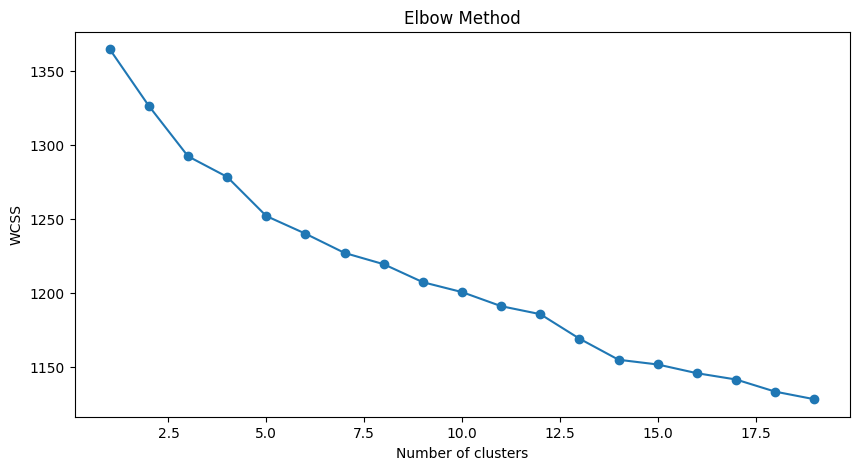

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_cluster['context'])

# Elbow Method
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
# 
plt.figure(figsize=(10, 5))
plt.plot(range(1, 20), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
kCluster = KMeans(n_clusters = 13, random_state=SEED)
kCluster.fit(X)
df_cluster["bill_type"] = kCluster.labels_


## Visualize Clusters
1. Display Graph of Clusters
2. Barchart of Clusters
3. Text Summary Length
4. Accuracy/Precision Metrics
5. Ask Dr. Masino if theres any other helpful visualizations


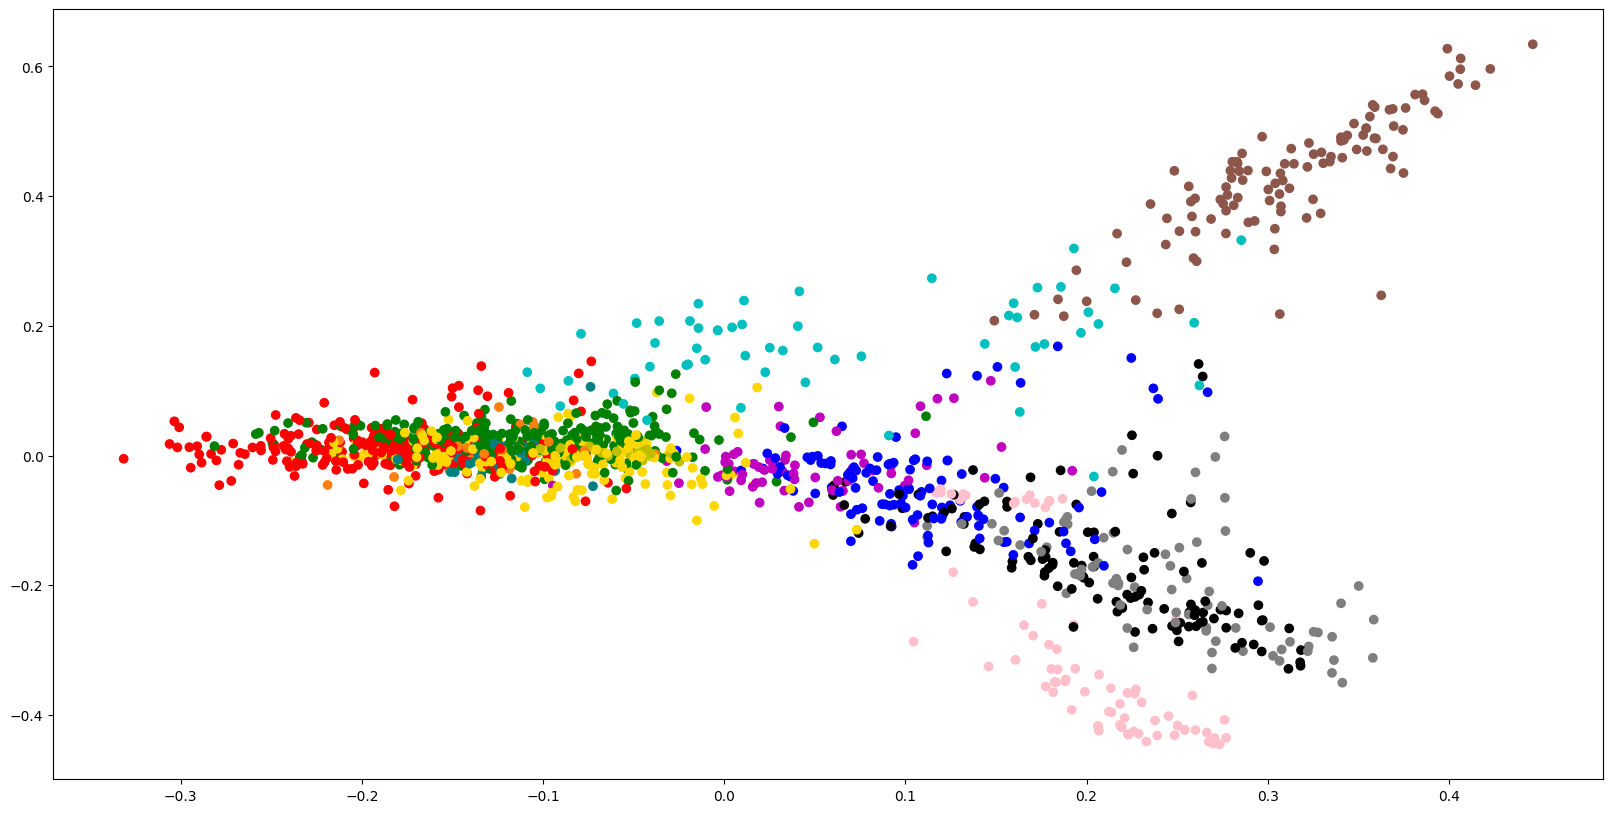

In [26]:
# Optional: Visualize clusters using PCA
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())

colors = ["b", "g", "r", "c", "m", "y", "k", "tab:brown", "tab:orange", "tab:gray", "gold", "teal", "pink"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in df_cluster["bill_type"]])

# for i, txt in enumerate(df["title"]):
#     ax.annotate(txt, (x_axis[i], y_axis[i]))

plt.show()

## Train Classifier on clustered data

## Data Processing for classifier

In [15]:
df_cluster.head()

##IMPORTANT FOR INTIAL CLASSIFIER PREPROCESSING STEP
## IN FUTURE DROP BILLS FROM COMITTES THAT ARE IRRELEVANT. ITS beyond scope because i need more poli sci knowledge
## specifically house resolutions should be dropped as columns or consolidated early because when the classifier sees them it adds too many categories. 

,title,description,context,bill_type
24612,Workers' Compensation Commission,"Repeal Act 233 Of 2018, Relating To The Provis...",worker compensation commission repeal act of r...,10
12237,Dr. Tsai Ing-wen & Chen Chien-Jen,"Congratulate Her Excellency Dr. Tsai Ing-wen, ...",dr tsai ingwen chen chienjen congratulate her ...,0
2735,Establish A Specified Procedure For The Enactm...,A JOINT RESOLUTION PROPOSING AN AMENDMENT TO A...,establish a specified procedure for the enactm...,10
1117,Express The Appreciation Of The South Carolina...,A HOUSE RESOLUTION TO EXPRESS THE APPRECIATION...,express the appreciation of the south carolina...,0
785,Provide That When A Person Is Convicted Of Or ...,A BILL TO AMEND THE CODE OF LAWS OF SOUTH CARO...,provide that when a person is convicted of or ...,1


In [16]:
# #save samples to csv and read so I can categorize them
# df_sample = df_cluster.groupby("bill_type").apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)
# df_sample.to_csv("../data/sample_bills_by_type.csv", index=False)

In [17]:

# # Assign Numerical Labels to meaning ful names
# bill_type_mapping = {
#     0: "congratulate",
#     1: "Criminal Justice",
#     2: "Legal Code",
#     3: "Education",
#     4: "Recognize",
#     5: "Request",
#     6: "Transportation",
#     7: "Sports",
#     8: "Small Buisness",
#     9: "Retirement",
#     10: "tbd",
#     11: "tbd2",
#     12: "Sorrow"
# }

# # Replace numerical labels with corresponding names
# df["bill_type"] = df["bill_type"].map(bill_type_mapping)

# # Select one bill per unique bill type
# df_sample = df.groupby("bill_type").first().reset_index()[["bill_type", "context"]]

# # Display results
# print(df_sample)

# # (Optional) Save to a new CSV file
# df_sample.to_csv("../data/sample_bills_by_type.csv", index=False)

## Train Classifier

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

X = df_cluster["context"]
y = df_cluster["bill_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

model = make_pipeline(TfidfVectorizer(), XGBClassifier(eval_metric='mlogloss')) ## I should beak at the documentation for this.

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.86      0.83      0.84        69
           2       0.81      1.00      0.89        51
           3       0.83      0.83      0.83        12
           4       0.75      0.67      0.71         9
           5       1.00      0.89      0.94         9
           6       0.89      1.00      0.94        24
           7       1.00      0.95      0.98        21
           8       0.50      1.00      0.67         1
           9       0.85      0.96      0.90        23
          10       0.87      0.63      0.73        43
          11       1.00      1.00      1.00         3
          12       1.00      0.93      0.96        14

    accuracy                           0.86       300
   macro avg       0.86      0.88      0.86       300
weighted avg       0.87      0.86      0.86       300



In [19]:
## use model to predict Large Dataset

df_Bill["bill_type"] = model.predict(df_Bill["context"])

,title,description,context,bill_type
0,Correct A Reference; And To Repeal Section 16-...,"A BILL TO AMEND SECTION 16-23-460, AS AMENDED,...",correct a reference and to repeal section rela...,2
1,Include Powers To Enforce Certain Laws Related...,A BILL TO AMEND THE CODE OF LAWS OF SOUTH CARO...,include power to enforce certain law related t...,10
2,Require A Poll Manager To Compare The Photogra...,"A BILL TO AMEND SECTION 7-5-125, AS AMENDED, C...",require a poll manager to compare the photogra...,2
3,Postpone The Implementation Of The Transfer Va...,"A BILL TO AMEND SECTION 12-37-3140, AS AMENDED...",postpone the implementation of the transfer va...,2
4,Provide That Trust Funds And Any Other Public ...,"A BILL TO AMEND SECTION 48-59-100, CODE OF LAW...",provide that trust fund and any other public f...,1
